In [ ]:
import random
import numpy as np
import cv2
import csv
import pickle
import requests
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f);

with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f);

with open('german-traffic-signs/valid.p', 'rb') as f:
  validation_data = pickle.load(f);

X_train = train_data['features'];
y_train = train_data['labels'];
X_validate = validation_data['features'];
y_validate = validation_data['labels'];
X_test = test_data['features'];
y_test = test_data['labels'];

In [ ]:
data = None;

with open('german-traffic-signs/signnames.csv', newline='') as csvfile:
  data = csv.reader(csvfile, delimiter=" ", quotechar="|");
  for row in data:
    print(' '.join(row));

ClassId,SignName
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)
9,No passing
10,No passing for vechiles over 3.5 metric tons
11,Right-of-way at the next intersection
12,Priority road
13,Yield
14,Stop
15,No vechiles
16,Vechiles over 3.5 metric tons prohibited
17,No entry
18,General caution
19,Dangerous curve to the left
20,Dangerous curve to the right
21,Double curve
22,Bumpy road
23,Slippery road
24,Road narrows on the right
25,Road work
26,Traffic signals
27,Pedestrians
28,Children crossing
29,Bicycles crossing
30,Beware of ice/snow
31,Wild animals crossing
32,End of all speed and passing limits
33,Turn right ahead
34,Turn left ahead
35,Ahead only
36,Go straight or right
37,Go straight or left
38,Keep right
39,Keep left
40,Roundabout mandatory
41,End of no passing
42,End of no passing by vechiles over 3.5 metric tons


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


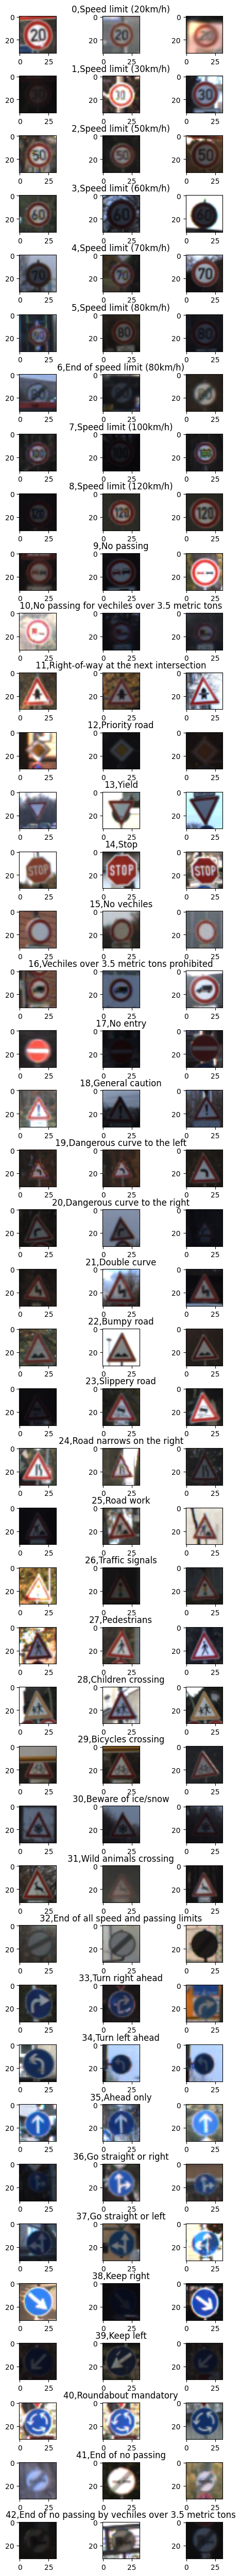

In [ ]:
cols = 3;
rows = 43;

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(5,50))
fig.tight_layout();

with open('german-traffic-signs/signnames.csv', newline='') as csvfile:
  data = csv.reader(csvfile, delimiter=" ", quotechar="|");
  for row in data:
    id = row[0].split(sep=',');
    for i in range(cols):
      if (id[0] != "ClassId"):
        currentSignGroup = X_train[y_train == int(id[0])];
        axs[int(id[0])][i].imshow(currentSignGroup[random.randint(0, (len(currentSignGroup) - 1)), :, :]);
        if i == 1:
          axs[int(id[0])][i].set_title(' '.join(row));

In [ ]:
def preprocessImage(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY);
  img = cv2.equalizeHist(img);
  img = img/255;
  return img;

X_train = np.array(list(map(preprocessImage, X_train)));
X_validate = np.array(list(map(preprocessImage, X_validate)));
X_test = np.array(list(map(preprocessImage, X_test)));

X_train = X_train.reshape(34799, 32, 32, 1);
X_test = X_test.reshape(12630, 32, 32, 1);
X_validate = X_validate.reshape(4410, 32, 32, 1);

In [ ]:
datagen=ImageDataGenerator(width_shift_range=0.1,
                   height_shift_range=0.2,
                   zoom_range=0.1,
                   shear_range=0.1,
                   rotation_range=15)

datagen.fit(X_train)

In [ ]:
y_train = to_categorical(y_train, 43);
y_test = to_categorical(y_test, 43);
y_validate = to_categorical(y_validate, 43);

In [ ]:
def AI():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

  model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = AI();
print(model.summary());

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_37 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_39 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                 

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=len(X_train) / 50,
                            epochs=10,
                            validation_data=(X_validate, y_validate),
                            shuffle = 1,
                            )

Epoch 1/10
695/695 [==============================] - 16s 21ms/step - loss: 2.2747 - accuracy: 0.3617 - val_loss: 0.5620 - val_accuracy: 0.8299
Epoch 2/10
695/695 [==============================] - 15s 21ms/step - loss: 0.7971 - accuracy: 0.7578 - val_loss: 0.2574 - val_accuracy: 0.9170
Epoch 3/10
695/695 [==============================] - 15s 21ms/step - loss: 0.4730 - accuracy: 0.8559 - val_loss: 0.1836 - val_accuracy: 0.9447
Epoch 4/10
695/695 [==============================] - 15s 21ms/step - loss: 0.3353 - accuracy: 0.8974 - val_loss: 0.1871 - val_accuracy: 0.9415
Epoch 5/10
695/695 [==============================] - 17s 25ms/step - loss: 0.2781 - accuracy: 0.9142 - val_loss: 0.1200 - val_accuracy: 0.9642
Epoch 6/10
695/695 [==============================] - 15s 22ms/step - loss: 0.2376 - accuracy: 0.9259 - val_loss: 0.1323 - val_accuracy: 0.9624
Epoch 7/10
695/695 [==============================] - 15s 22ms/step - loss: 0.2066 - accuracy: 0.9342 - val_loss: 0.0972 - val_accuracy:

Text(0, 0.5, 'delta')

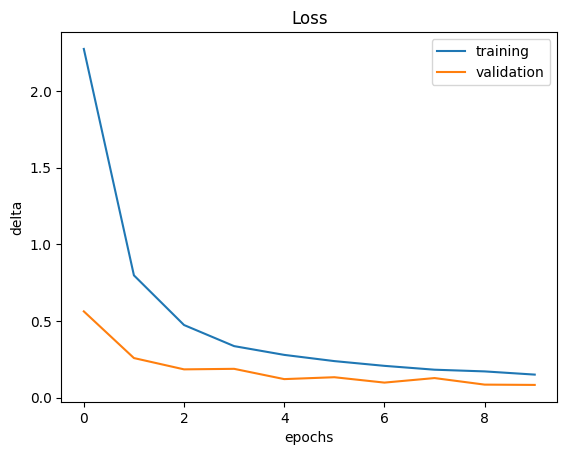

In [ ]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.legend(['training', 'validation']);
plt.title('Loss');
plt.xlabel('epochs');
plt.ylabel('delta')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Rezultāts: ', score[0])
print('Precizitāte: ' , score[1])

Rezultāts:  0.1826670914888382
Precizitāte:  0.9572446346282959


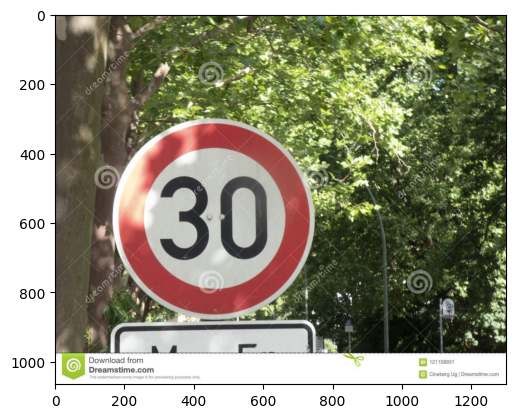

In [ ]:
res = requests.get("https://thumbs.dreamstime.com/z/kmh-speed-limit-sign-typical-km-h-speed-limit-sign-used-germany-121108931.jpg", stream=True);
img = Image.open(res.raw);
plt.imshow(img);

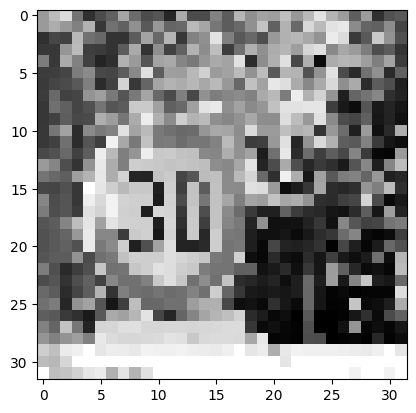

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessImage(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))

In [ ]:
img = img.reshape(1, 32, 32, 1)
predict_x=model.predict(img)
classes_x=np.argmax(predict_x,axis=1)

print('Zimēs minētais indeks: ' + str(classes_x))

1/1 [==============================] - 0s 17ms/step
Zimēs minētais indeks: [1]
